Following this
---
https://towardsdatascience.com/a-step-by-step-guide-to-feature-engineering-for-multivariate-time-series-162ccf232e2f

In [23]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns #For heatmap
from utils import time_delay_embedding

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [24]:
train_a = pd.read_parquet('data/A/train_targets.parquet')
train_b = pd.read_parquet('data/B/train_targets.parquet')
train_c = pd.read_parquet('data/C/train_targets.parquet')

# Estimated training data for each location
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

# Observed training data for each location
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

# Estimated test data for each location
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

For the sake of it looking at only one dataset.
Might do something else later

In [25]:
X_data = X_train_observed_a
Y_data = train_a

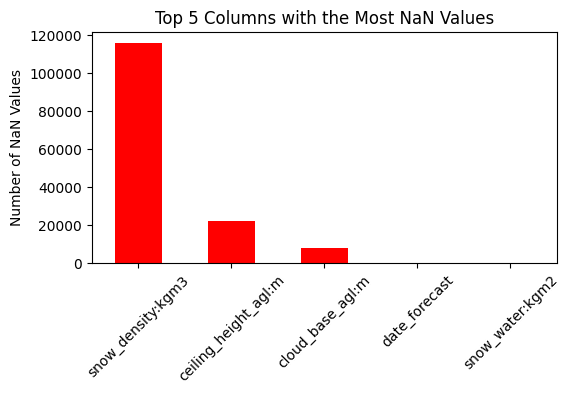

In [26]:
nan_count = X_data.isnull().sum()
sorted_nan_count = nan_count.sort_values(ascending=False)
N = 5  # Change this to the number of columns you want to plot
columns_to_plot = sorted_nan_count.head(N)
plt.figure(figsize=(6, 3))
columns_to_plot.plot(kind='bar', color='red')
plt.title(f'Top {N} Columns with the Most NaN Values')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.show()

I will remove snow density

In [27]:
X_data.drop(columns=['snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m'], inplace=True)

In [28]:
X_data.rename(columns={'date_forecast': 'time'}, inplace=True)
X_data = X_data.set_index('time')
X_data = X_data.resample('H').mean()

Y_data.set_index('time')
data = pd.merge(X_data, Y_data, on="time")
data.set_index('time')

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,7.700,1.22825,0.000000,0.00,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1006.299988,0.0,0.0,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,0.0,0.0,0.0,0.175,348.036743,-3.774250,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,0.00
2019-06-02 23:00:00,7.700,1.22350,0.000000,0.00,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.750000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1005.200012,0.0,0.0,992.674988,998.650024,0.0,0.025,68.000000,1004.650024,0.0,0.0,0.0,0.200,91.980751,-4.357250,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,0.00
2019-06-03 00:00:00,7.875,1.21975,0.000000,0.00,0.0,280.649994,0.000,0.000000,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1004.525024,0.0,0.0,992.000000,997.974976,0.0,0.100,67.949997,1003.950012,0.0,0.0,0.0,0.400,14.934750,-3.309500,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,0.00
2019-06-03 01:00:00,8.425,1.21800,208.649994,0.75,0.0,281.674988,0.300,526.775024,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1004.025024,0.0,0.0,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,0.0,0.0,0.0,0.550,28.630251,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,0.00
2019-06-03 02:00:00,8.950,1.21800,32468.150391,23.10,0.0,282.500000,11.975,22068.949219,0.15,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,0.0,0.0,0.0,0.250,41.997501,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 20:00:00,5.800,1.28050,0.000000,0.00,0.0,275.799988,0.000,0.000000,0.00,0.000000,38.125000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1019.500000,0.0,0.0,1006.599976,1012.849976,0.0,0.000,78.649994,1019.125000,0.0,0.0,0.0,0.000,313.254761,-29.704250,0.0,278.250000,47.050003,40105.472656,1.925,0.475,1.850,0.0,0.00
2022-10-20 21:00:00,5.575,1.28400,0.000000,0.00,0.0,275.200012,0.000,0.000000,0.00,0.000000,16.275000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1019.250000,0.0,0.0,1006.375000,1012.625000,0.0,0.000,79.125000,1018.900024,0.0,0.0,0.0,0.000,329.987762,-33.860748,0.0,277.850006,19.500000,39001.398438,1.675,0.250,1.675,0.0,0.00
2022-10-20 22:00:00,5.350,1.28700,0.000000,0.00,0.0,274.600006,0.000,0.000000,0.00,0.000000,9.700000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1018.974976,0.0,0.0,1006.099976,1012.349976,0.0,0.000,79.974998,1018.650024,0.0,0.0,0.0,0.000,347.845490,-36.270000,0.0,277.475006,9.700000,35336.726562,1.400,0.050,1.400,0.0,0.00


In [29]:
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #remove the : characters etc. This is due json stuff. clear_sky_rad:W-> clear_sky_radW

In [30]:
import xgboost as xgb

Y = data['pv_measurement']
X = data.drop(columns=['time', 'pv_measurement'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, Y_train)

/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 1.0, 'Feature Importance')

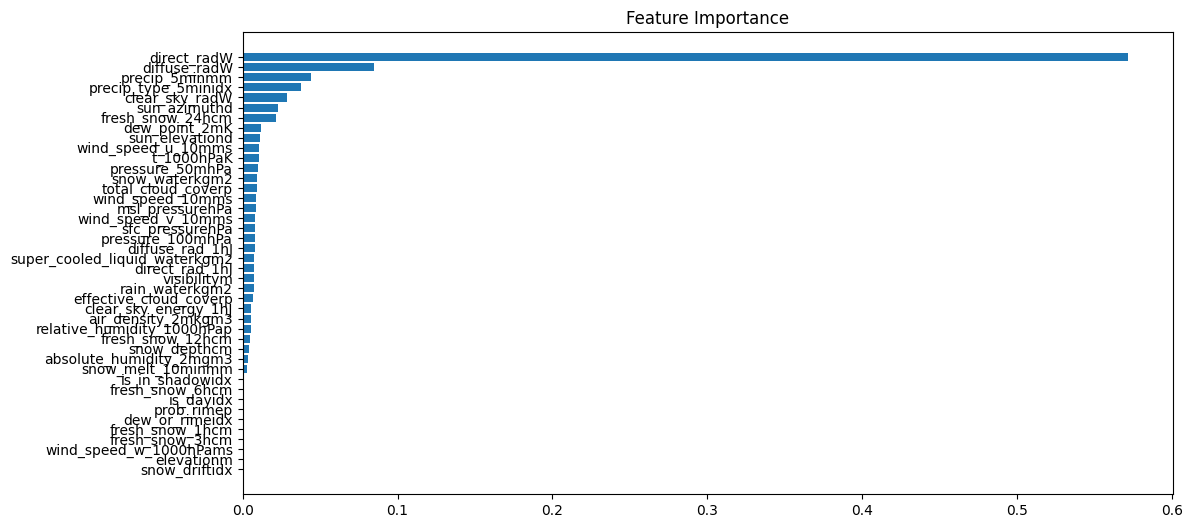

In [31]:

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')


Laplacian score and variance treshold